In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
from torchvision import models

In [2]:
import matplotlib.pyplot as plt
import tempfile

# Transfer Learning

First we declare some utility functions that will help us encapsulate the process

In [3]:
def get_cifar10_loaders(num_train=45000, batch_size=64, data_path=None):
    """
    Creates and returns DataLoaders for CIFAR-10 dataset with proper transformations
    for transfer learning.

    Args:
        num_train (int): Number of training samples (default: 45000)
        batch_size (int): Size of mini-batches (default: 64)
        data_path (str): Path to store/load dataset. If None, uses temp directory

    Returns:
        tuple: (train_loader, val_loader, test_loader)
    """
    # Use temporary directory if no path specified
    if data_path is None:
        import tempfile
        data_path = tempfile.gettempdir()

    # Define transformations for transfer learning with ImageNet models
    transform_imagenet = T.Compose([
        T.Resize(224),                # Resize images to ImageNet size
        T.ToTensor(),                 # Convert to tensor (0-1 range)
        # ImageNet normalization values
        T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    # Load training dataset and create train/val split
    cifar10_train = datasets.CIFAR10(data_path,
                                    train=True,
                                    download=True,
                                    transform=transform_imagenet)

    # Create training loader with subset sampler
    train_loader = DataLoader(
        cifar10_train,
        batch_size=batch_size,
        sampler=sampler.SubsetRandomSampler(range(num_train))
    )

    # Create validation loader with remaining training data
    val_loader = DataLoader(
        cifar10_train,
        batch_size=batch_size,
        sampler=sampler.SubsetRandomSampler(range(num_train, len(cifar10_train)))
    )

    # Load and create test loader
    cifar10_test = datasets.CIFAR10(data_path,
                                   train=False,
                                   download=True,
                                   transform=transform_imagenet)
    test_loader = DataLoader(cifar10_test, batch_size=batch_size)

    return train_loader, val_loader, test_loader

In [4]:
def get_device(force_cpu=False):
    """
    Returns the best available device for PyTorch operations.

    Args:
        force_cpu (bool): If True, will return CPU even if CUDA is available
                         Useful for debugging or when GPU memory is limited

    Returns:
        torch.device: 'cuda' if GPU is available (and force_cpu=False), 'cpu' otherwise

    Example:
        >>> device = get_device()
        >>> model = model.to(device)
        >>> tensor = tensor.to(device)
    """
    if not force_cpu and torch.cuda.is_available():
        device = torch.device('cuda')
        print(f'Using CUDA device: {torch.cuda.get_device_name(0)}')
    else:
        device = torch.device('cpu')
        print('Using CPU')

    return device

In [5]:
def plot_random_sample(loader, classes=None):
    """
    Randomly selects and plots an image from a DataLoader with its corresponding label.

    Args:
        loader (DataLoader): PyTorch DataLoader containing the dataset
        classes (list, optional): List of class names. If None, will only show class index

    Returns:
        tuple: (image_tensor, label) of the plotted sample

    Example:
        >>> classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
        >>> plot_random_sample(test_loader, classes)
    """
    # Get a random index
    rnd_sample_idx = np.random.randint(len(loader.dataset))

    # Get the image and label
    image, label = loader.dataset[rnd_sample_idx]

    # Normalize image for visualization
    image_normalized = (image - image.min()) / (image.max() - image.min())

    # Print the class
    if classes:
        print(f'This image represents: {classes[label]}')
    else:
        print(f'Class index: {label}')

    # Plot the image
    plt.figure(figsize=(6, 6))
    plt.imshow(image_normalized.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

    return image, label

In [6]:
def accuracy(model, loader):
    """
    Calculate the accuracy of a model on a given dataset.

    Args:
        model: PyTorch model to evaluate
        loader: DataLoader containing the dataset

    Returns:
        float: Accuracy score between 0 and 1
    """
    # Initialize counters for correct predictions and total samples
    num_correct = 0
    num_total = 0

    # Set model to evaluation mode (disables dropout, batch norm adjustments, etc.)
    model.eval()
    # Ensure model is on the correct device
    model = model.to(device=device)

    # Disable gradient calculations for efficiency during evaluation
    with torch.no_grad():
        # Iterate through batches in the data loader
        for (xi, yi) in loader:
            # Move input data to the same device as model
            xi = xi.to(device=device, dtype=torch.float32)  # Move images
            yi = yi.to(device=device, dtype=torch.long)     # Move labels

            # Forward pass: get model predictions
            scores = model(xi)  # Shape: [batch_size, num_classes]

            # Get the predicted class (highest score) for each sample
            _, pred = scores.max(dim=1)  # Shape: [batch_size]

            # Count correct predictions
            num_correct += (pred == yi).sum()  # Compare predictions with true labels

            # Update total number of samples processed
            num_total += pred.size(0)  # Add batch size

        # Calculate and return accuracy as a percentage
        return float(num_correct) / num_total

In [7]:
def get_pretrained_model(model_name='resnet18', num_classes=10):
    """
    Get a pretrained model from PyTorch's model zoo and configure it for the target task.

    Args:
        model_name (str): Name of the pretrained model to load
            Options: 'resnet18', 'resnet34', 'resnet50', 'vgg16', 'densenet121'
        num_classes (int): Number of classes for the final layer

    Returns:
        model: Configured PyTorch model with modified classification layer

    Raises:
        ValueError: If model_name is not supported
    """
    # Dictionary of supported models and their constructors
    models_dict = {
        'resnet18': models.resnet18,
        'resnet34': models.resnet34,
        'resnet50': models.resnet50,
        'vgg16': models.vgg16,
        'densenet121': models.densenet121
    }

    # Check if requested model is supported
    if model_name not in models_dict:
        raise ValueError(f"Model {model_name} not supported. Choose from: {list(models_dict.keys())}")

    # Load pretrained model
    print(f"Loading pretrained {model_name}...")
    model = models_dict[model_name](pretrained=True)

    # Modify the final layer based on model architecture
    if 'resnet' in model_name:
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, num_classes)
    elif model_name == 'vgg16':
        num_features = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(num_features, num_classes)
    elif model_name == 'densenet121':
        num_features = model.classifier.in_features
        model.classifier = nn.Linear(num_features, num_classes)

    print(f"Model configured with {num_classes} output classes")
    return model

# Example usage:
def freeze_model_features(model, model_name):
    """
    Freeze all feature extraction layers, leaving only the final classifier trainable.
    """
    # Freeze all parameters
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze the final layer(s) based on architecture
    if 'resnet' in model_name:
        for param in model.fc.parameters():
            param.requires_grad = True
    elif model_name == 'vgg16':
        for param in model.classifier[-1].parameters():
            param.requires_grad = True
    elif model_name == 'densenet121':
        for param in model.classifier.parameters():
            param.requires_grad = True

    print("Feature extraction layers frozen")

def unfreeze_model_features(model):
    """
    Unfreeze all model parameters for fine-tuning.
    """
    for param in model.parameters():
        param.requires_grad = True
    print("All layers unfrozen for fine-tuning")


In [8]:
def adapt_model_for_cifar10(pretrained_model, hidden_features=512, num_classes=10,
                           add_dropout=False, dropout_rate=0.5):
    """
    Enhanced version with optional dropout for regularization.
    """
    # Extract feature extractor
    feature_extractor = nn.Sequential(*list(pretrained_model.children())[:-1])

    # Create layers list
    layers = [
        feature_extractor,
        nn.Flatten()
    ]

    # Optionally add dropout for regularization
    if add_dropout:
        layers.append(nn.Dropout(p=dropout_rate))

    # Add final classification layer
    layers.append(
        nn.Linear(in_features=hidden_features,
                 out_features=num_classes,
                 bias=True)
    )

    # Create sequential model
    adapted_model = nn.Sequential(*layers)

    print(f"Model adapted for {num_classes} classes")
    print(f"Feature extractor output size: {hidden_features}")
    if add_dropout:
        print(f"Dropout added with rate: {dropout_rate}")

    return adapted_model


In [9]:
def train(model, optimiser, epochs=100):
    """
    Train a PyTorch model using the specified optimizer.

    Args:
        model: PyTorch model to train
        optimiser: PyTorch optimizer for updating model parameters
        epochs (int): Number of training epochs (default: 100)

    Note:
        - Uses global train_loader for training data
        - Uses global val_loader for validation
        - Uses global device for GPU/CPU placement
    """
    # Move model to appropriate device (GPU/CPU)
    model = model.to(device=device)

    # Training loop over epochs
    for epoch in range(epochs):
        # Inner loop over batches in training data
        for i, (xi, yi) in enumerate(train_loader):
            # Set model to training mode (enables dropout, batch norm, etc.)
            model.train()

            # Move batch data to appropriate device
            xi = xi.to(device=device, dtype=torch.float32)  # Input images
            yi = yi.to(device=device, dtype=torch.long)     # Labels

            # Forward pass: compute predictions
            scores = model(xi)

            # Compute loss
            cost = F.cross_entropy(input=scores, target=yi)

            # Backward pass and optimization
            optimiser.zero_grad()           # Clear previous gradients
            cost.backward()                 # Compute gradients
            optimiser.step()                # Update weights

        # Compute validation accuracy after each epoch
        acc = accuracy(model, val_loader)
        print(f'Epoch: {epoch}, costo: {cost.item()}, accuracy: {acc},')


# Data download


100%|██████████| 170M/170M [00:18<00:00, 8.99MB/s]


Extracting /tmp/cifar-10-python.tar.gz to /tmp
Files already downloaded and verified
Using CUDA device: Tesla T4

Viewing random samples from training data:
This image represents: Frog


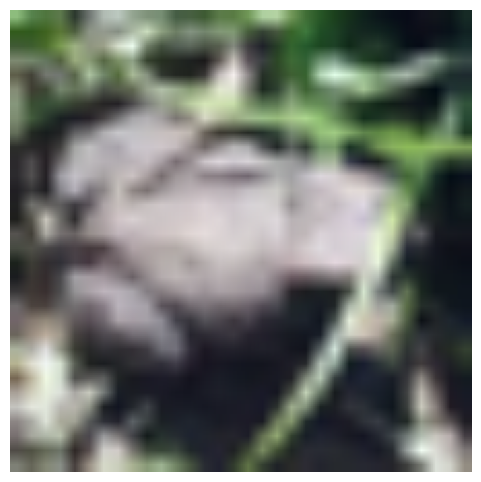

In [10]:
# Get the data ready
train_loader, val_loader, test_loader = get_cifar10_loaders()
device = get_device()

# Define CIFAR-10 classes for better visualization
cifar10_classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer',
                   'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Visualize some random samples from training data
print("\nViewing random samples from training data:")
for _ in range(1):  # Show 3 random samples
    plot_random_sample(train_loader, cifar10_classes)



## Transfer Learning resnet18


In [11]:
# 1. Get pretrained model
model_name = 'resnet18'
pretrained_model = get_pretrained_model(model_name)

# 2. Freeze feature extraction layers BEFORE adapting the model
freeze_model_features(pretrained_model, model_name)

# 3. THEN remove linear layers and add new ones for CIFAR-10
model = adapt_model_for_cifar10(
    pretrained_model=pretrained_model,
    hidden_features=512,  # ResNet18's feature size
    num_classes=10       # CIFAR-10 classes
)

# Move model to appropriate device
model = model.to(device)


# Higher learning rate since we're only training the classifier
initial_lr = 1e-3
optimizer = torch.optim.Adam(
    [param for param in model.parameters() if param.requires_grad],
    lr=initial_lr
)
# Train only the classifier (with frozen features)
print("Training classifier with frozen features...")
train(model, optimizer, epochs=5)  # Fewer epochs for initial training



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


Loading pretrained resnet18...


100%|██████████| 44.7M/44.7M [00:00<00:00, 127MB/s]


Model configured with 10 output classes
Feature extraction layers frozen
Model adapted for 10 classes
Feature extractor output size: 512
Training classifier with frozen features...
Epoch: 0, costo: 0.5834542512893677, accuracy: 0.7802,
Epoch: 1, costo: 1.4958668947219849, accuracy: 0.791,
Epoch: 2, costo: 0.9462931752204895, accuracy: 0.8002,
Epoch: 3, costo: 0.8007484078407288, accuracy: 0.8014,
Epoch: 4, costo: 0.3531852662563324, accuracy: 0.8038,


In [12]:
# 4. Unfreeze the model for fine-tuning
unfreeze_model_features(model)

# 5. Continue training with lower learning rate
fine_tune_lr = 1e-4  # Lower learning rate for fine-tuning
optimizer = torch.optim.Adam(model.parameters(), lr=fine_tune_lr)

print("Fine-tuning entire model...")
train(model, optimizer, epochs=3)  # Few epochs of fine-tuning

All layers unfrozen for fine-tuning
Fine-tuning entire model...
Epoch: 0, costo: 0.02392934262752533, accuracy: 0.9304,
Epoch: 1, costo: 0.9383550882339478, accuracy: 0.9318,
Epoch: 2, costo: 0.03903578221797943, accuracy: 0.9382,


In [13]:
# 6. Evaluate final model
final_accuracy = accuracy(model, test_loader)
print(f"Final test accuracy: {final_accuracy:.4f}")

Final test accuracy: 0.9394


# Transfer Learning ResNet34

In [14]:
# 2. Get pretrained ResNet34 model
model_name = 'resnet34'
pretrained_model = get_pretrained_model(model_name)

# 3. Freeze feature extraction layers BEFORE adapting the model
freeze_model_features(pretrained_model, model_name)

# 4. THEN remove linear layers and add new ones for CIFAR-10
model = adapt_model_for_cifar10(
    pretrained_model=pretrained_model,
    hidden_features=512,  # ResNet34's feature size (same as ResNet18)
    num_classes=10,      # CIFAR-10 classes
    add_dropout=True,    # Optional: add dropout for regularization
    dropout_rate=0.3     # Lower dropout rate than VGG16
)

# Move model to appropriate device
model = model.to(device)

# 5. Train only the classifier (with frozen features)
initial_lr = 1e-3
optimizer = torch.optim.Adam(
    [param for param in model.parameters() if param.requires_grad],
    lr=initial_lr
)

print("\nTraining classifier with frozen features...")
train(model, optimizer, epochs=5)



Loading pretrained resnet34...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 172MB/s]


Model configured with 10 output classes
Feature extraction layers frozen
Model adapted for 10 classes
Feature extractor output size: 512
Dropout added with rate: 0.3

Training classifier with frozen features...
Epoch: 0, costo: 0.6631810665130615, accuracy: 0.8008,
Epoch: 1, costo: 1.0409913063049316, accuracy: 0.796,
Epoch: 2, costo: 0.8487449884414673, accuracy: 0.8086,
Epoch: 3, costo: 1.4321333169937134, accuracy: 0.8118,
Epoch: 4, costo: 0.49722543358802795, accuracy: 0.8122,


In [15]:
# 6. Unfreeze for fine-tuning
unfreeze_model_features(model)

# 7. Continue training with lower learning rate
fine_tune_lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=fine_tune_lr)

print("\nFine-tuning entire model...")
train(model, optimizer, epochs=3)



All layers unfrozen for fine-tuning

Fine-tuning entire model...
Epoch: 0, costo: 0.5431694388389587, accuracy: 0.9424,
Epoch: 1, costo: 0.39397579431533813, accuracy: 0.9466,
Epoch: 2, costo: 1.163292646408081, accuracy: 0.9474,


In [16]:
# 8. Evaluate final model
final_accuracy = accuracy(model, test_loader)
print(f"\nFinal test accuracy: {final_accuracy:.4f}")


Final test accuracy: 0.9433


# Transfer learning ResNet50

In [17]:
# 2. Get pretrained ResNet50 model
model_name = 'resnet50'
pretrained_model = get_pretrained_model(model_name)

# 3. Freeze feature extraction layers BEFORE adapting the model
freeze_model_features(pretrained_model, model_name)

# 4. THEN remove linear layers and add new ones for CIFAR-10
model = adapt_model_for_cifar10(
    pretrained_model=pretrained_model,
    hidden_features=2048,  # ResNet50's feature size (4x larger than ResNet18/34!)
    num_classes=10,       # CIFAR-10 classes
    add_dropout=True,     # Add dropout for regularization
    dropout_rate=0.4      # Moderate dropout rate for larger model
)

# Move model to appropriate device
model = model.to(device)

# 5. Train only the classifier (with frozen features)
initial_lr = 5e-4  # Slightly lower initial learning rate for larger model
optimizer = torch.optim.Adam(
    [param for param in model.parameters() if param.requires_grad],
    lr=initial_lr
)

print("\nTraining classifier with frozen features...")
train(model, optimizer, epochs=5)



Loading pretrained resnet50...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 209MB/s]


Model configured with 10 output classes
Feature extraction layers frozen
Model adapted for 10 classes
Feature extractor output size: 2048
Dropout added with rate: 0.4

Training classifier with frozen features...
Epoch: 0, costo: 0.37570884823799133, accuracy: 0.793,
Epoch: 1, costo: 0.7104073166847229, accuracy: 0.808,
Epoch: 2, costo: 0.6052599549293518, accuracy: 0.8016,
Epoch: 3, costo: 1.0128252506256104, accuracy: 0.809,
Epoch: 4, costo: 0.5041074752807617, accuracy: 0.811,


In [18]:
# 6. Unfreeze for fine-tuning
unfreeze_model_features(model)

# 7. Continue training with lower learning rate
fine_tune_lr = 1e-5  # Even lower learning rate for fine-tuning
optimizer = torch.optim.Adam(model.parameters(), lr=fine_tune_lr)

print("\nFine-tuning entire model...")
train(model, optimizer, epochs=3)



All layers unfrozen for fine-tuning

Fine-tuning entire model...
Epoch: 0, costo: 0.6662977933883667, accuracy: 0.9346,
Epoch: 1, costo: 0.01479492336511612, accuracy: 0.9434,
Epoch: 2, costo: 0.689650297164917, accuracy: 0.9466,


In [19]:
# 8. Evaluate final model
final_accuracy = accuracy(model, test_loader)
print(f"\nFinal test accuracy: {final_accuracy:.4f}")


Final test accuracy: 0.9455
